In [1]:
from src.data_download import initialize_gee, download_dem
from src.calculations import calculate_terrain_attributes
from src.plotting import plot_all_bands, plot_individual_attribute
from src.utils import tiff_to_xarray, combine_xarrays
import os

Создадим пример - GeoJson файл с координатами области 
```
lat, lon = 55.600, 37.172
buffer = 0.1
```


In [2]:
import json

lat, lon = 55.600, 37.172
buffer = 0.1
min_lat = lat - buffer
max_lat = lat + buffer
min_lon = lon - buffer
max_lon = lon + buffer

sample_geojson = {
    "type": "FeatureCollection",
    "features": [
        {
            "type": "Feature",
            "geometry": {
                "type": "Polygon",
                "coordinates": [
                    [
                        [min_lon, min_lat],
                        [max_lon, min_lat],
                        [max_lon, max_lat],
                        [min_lon, max_lat],
                        [min_lon, min_lat]
                    ]
                ]
            },
            "properties": {
                # В данном примере отсутствует временной промежуток → null
                "time": None,
                # Поскольку передается прямоугольный полигон → true
                "is_rectangle": True
            }
        }
    ]
}

# Сохраним GeoJSON в файл
with open("sample.geojson", "w", encoding="utf-8") as f:
    json.dump(sample_geojson, f, ensure_ascii=False, indent=2)

In [3]:
# Инициализируем GEE
initialize_gee(project='projectomela')

# Определим координаты и названия файлов
geojson_path = "sample.geojson"
dem_file_name = "srtm.tif"
directory = "example_output"

# Загрузим DEM из GEE (DEM сохранится в tiff файл в директории directory)
dem_xarray = download_dem(geojson_path, dem_file_name, directory)
# Путь к DEM файлу
dem_path = os.path.join(directory, dem_file_name)
dem_xarray

Google Earth Engine успешно инициализирован.
Generating URL ...
Please wait ...
Data downloaded to c:\Users\Asus\dem_api\examples\srtm.tif
DEM downloaded to example_output\srtm.tif


<xarray.Dataset> Size: 1MB
Dimensions:      (time: 1, band: 1, x: 743, y: 743)
Coordinates:
  * time         (time) object 8B None
  * band         (band) int32 4B 1
  * x            (x) float64 6kB 37.07 37.07 37.07 37.07 ... 37.27 37.27 37.27
  * y            (y) float64 6kB 55.7 55.7 55.7 55.7 ... 55.5 55.5 55.5 55.5
    spatial_ref  int32 4B 0
Data variables:
    elevation    (time, band, y, x) int16 1MB 168 171 172 173 ... 170 170 170

In [4]:
# Определим, какие аттрибуты мы хотим считать
attributes = [
    'slope', 'hillshade', 'aspect', 'curvature', 'planform_curvature', 'profile_curvature',
    'maximum_curvature', 'topographic_position_index', 'terrain_ruggedness_index',
    'roughness', 'rugosity'
]

# Получаем список из len(attributes) + 1 объектов Xarray; также сохраняем их как GeoTIFF файлы
attribute_xarrays = calculate_terrain_attributes(dem_path, attributes, directory)
attribute_xarrays[1]

Coordinate system before reprojection Ellipsoid
Coordinate system after reprojection EPSG:32637


<xarray.DataArray (band: 1, y: 754, x: 441)> Size: 3MB
[332514 values with dtype=float64]
Coordinates:
  * band         (band) int32 4B 1
  * x            (x) float64 4kB 3.782e+05 3.782e+05 ... 3.914e+05 3.914e+05
  * y            (y) float64 6kB 6.174e+06 6.174e+06 ... 6.152e+06 6.152e+06
    spatial_ref  int32 4B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [5]:
# Объединим xarray DataArrays в один xarray.Dataset
combined_xarray = combine_xarrays(attribute_xarrays, attributes)
combined_xarray

<xarray.Dataset> Size: 8MB
Dimensions:                     (latitude: 754, longitude: 441)
Coordinates:
  * longitude                   (longitude) float64 4kB 3.782e+05 ... 3.914e+05
  * latitude                    (latitude) float64 6kB 6.174e+06 ... 6.152e+06
    spatial_ref                 int32 4B 0
Data variables:
    reprojected_dem             (latitude, longitude) float16 665kB nan ... nan
    slope                       (latitude, longitude) float16 665kB nan ... nan
    hillshade                   (latitude, longitude) float16 665kB nan ... nan
    aspect                      (latitude, longitude) float16 665kB nan ... nan
    curvature                   (latitude, longitude) float16 665kB nan ... nan
    planform_curvature          (latitude, longitude) float16 665kB nan ... nan
    profile_curvature           (latitude, longitude) float16 665kB nan ... nan
    maximum_curvature           (latitude, longitude) float16 665kB nan ... nan
    topographic_position_index  (latitude, longitude) float16 665kB nan ... nan
    terrain_ruggedness_index    (latitude, longitude) float16 665kB nan ... nan
    roughness                   (latitude, longitude) float16 665kB nan ... nan
    rugosity                    (latitude, longitude) float16 665kB nan ... nan
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

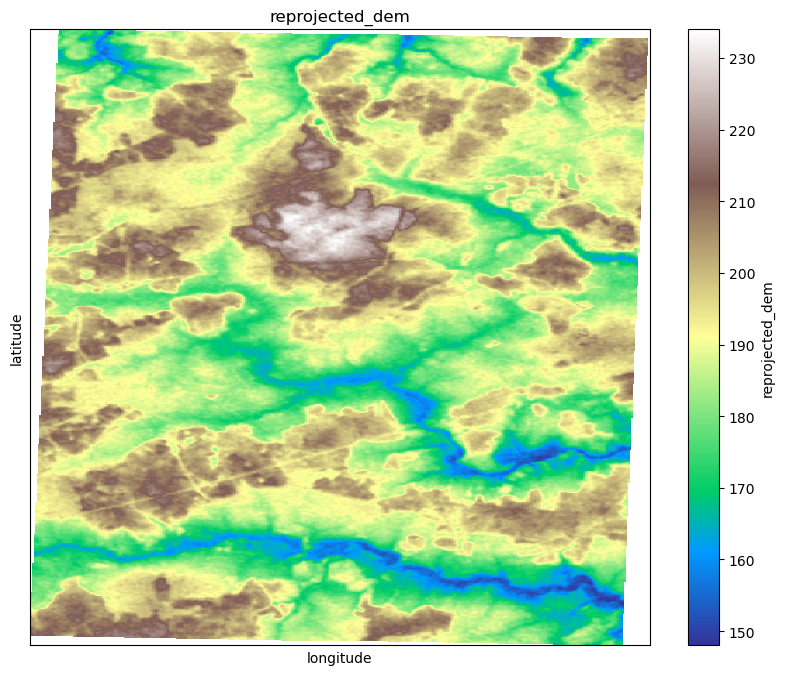

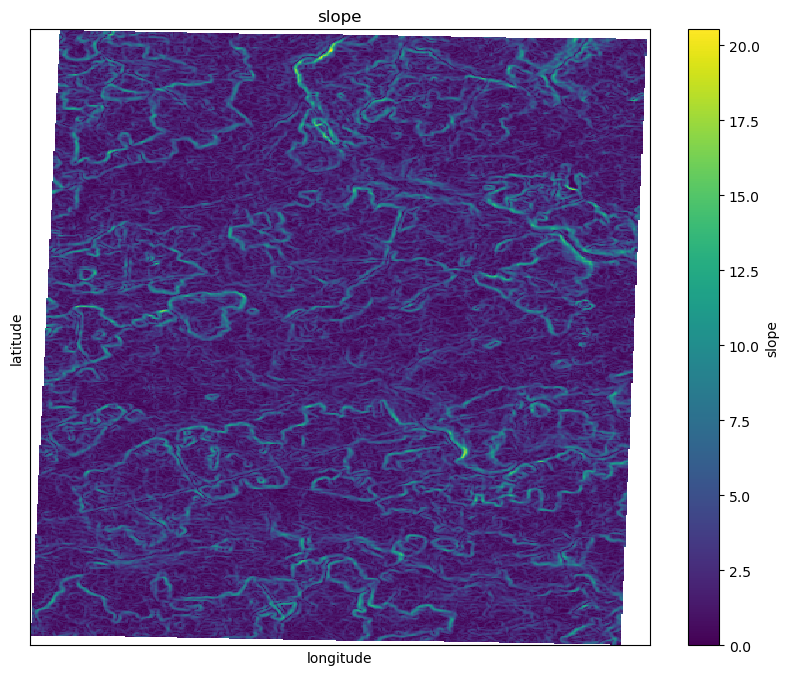

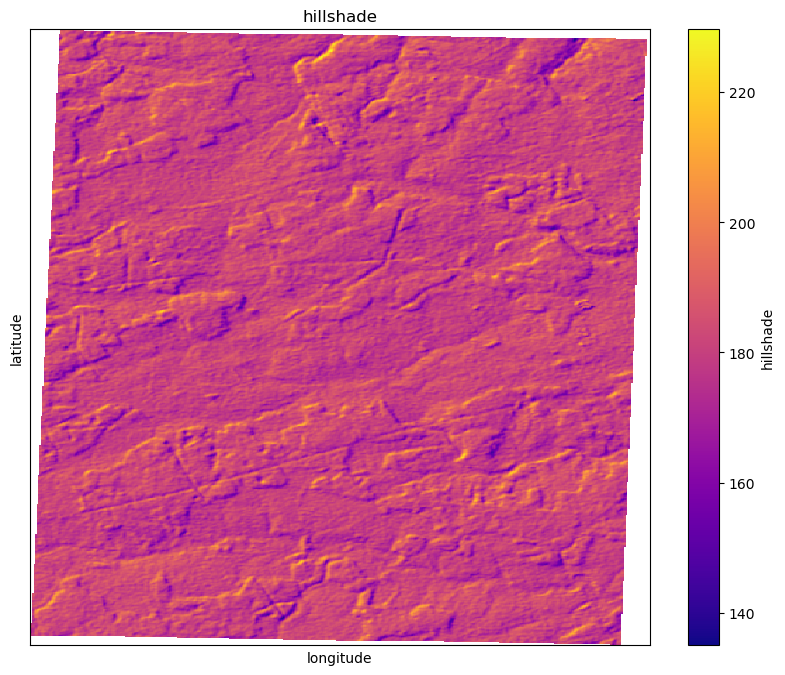

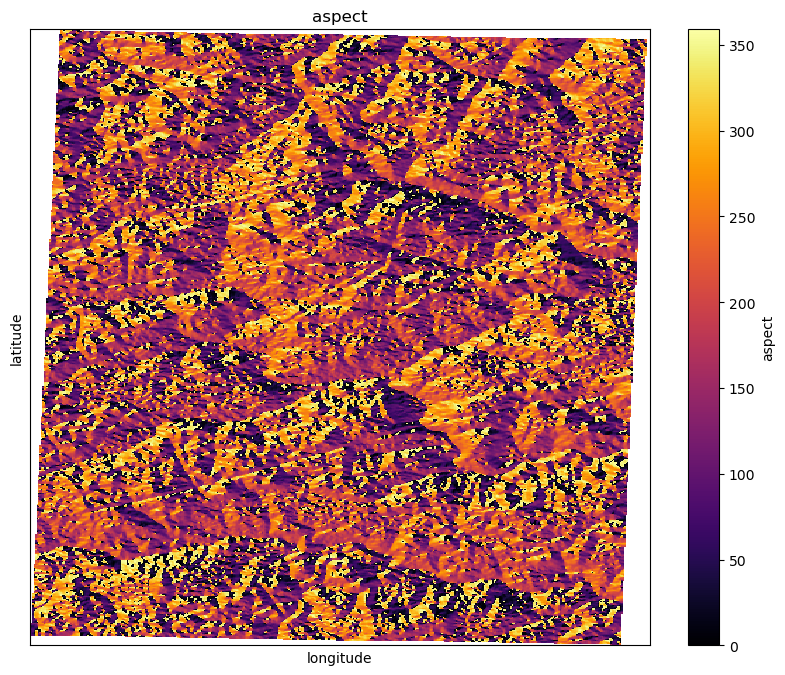

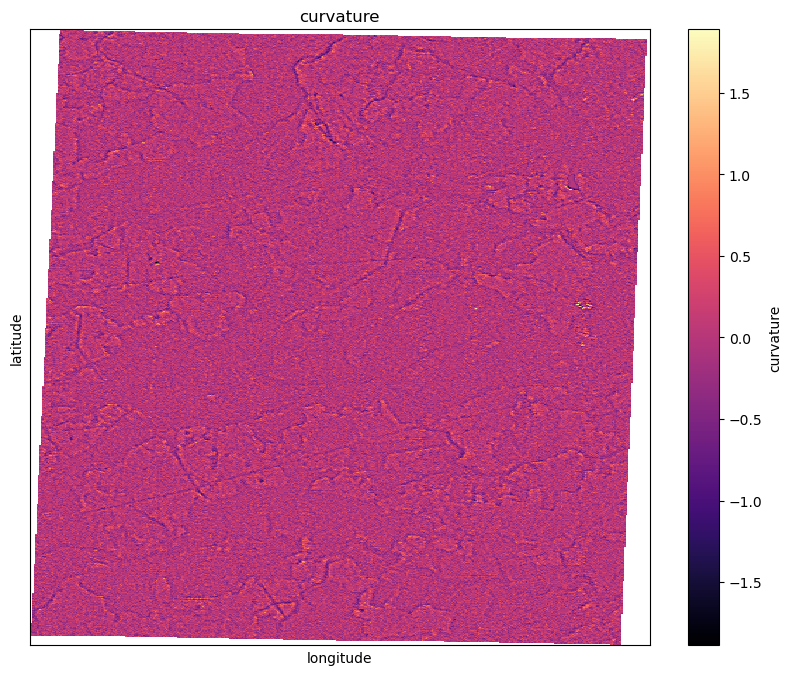

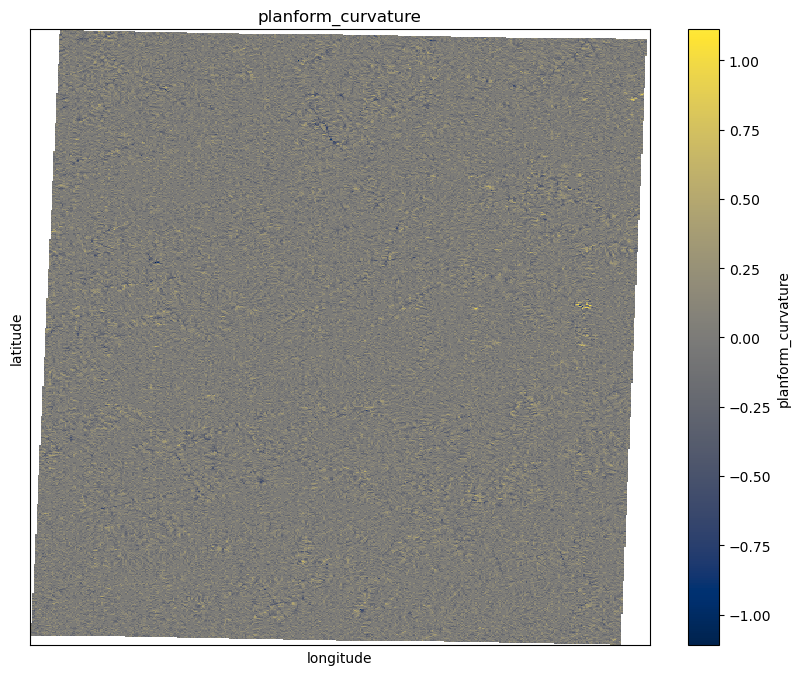

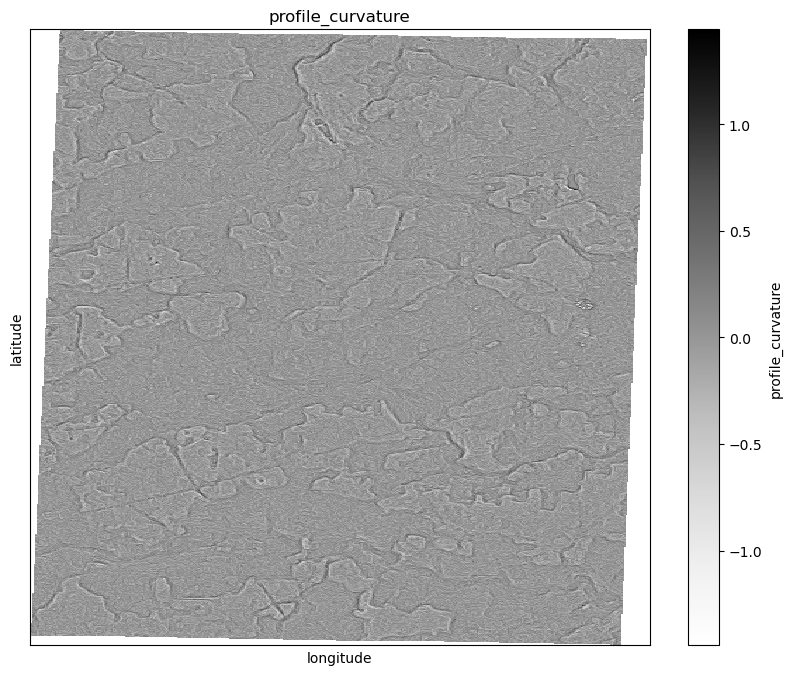

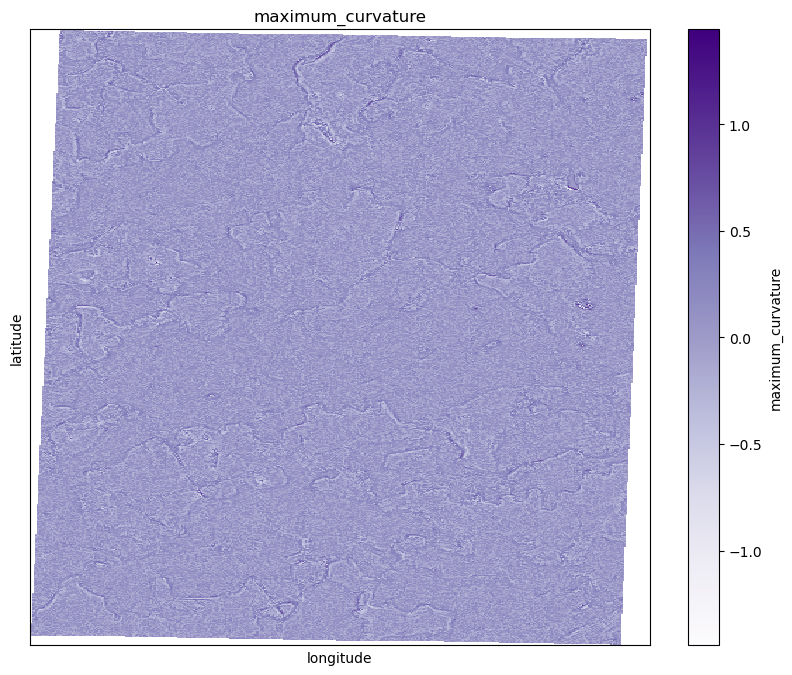

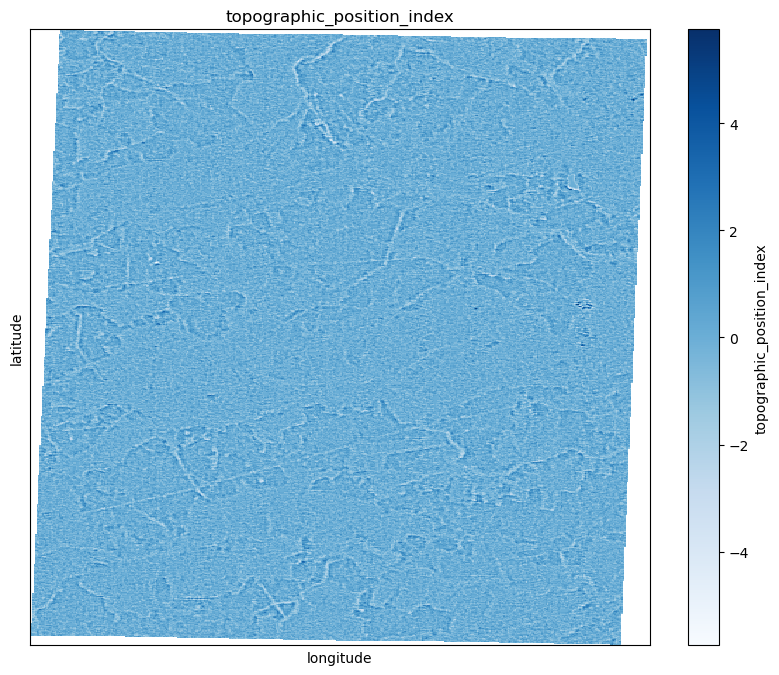

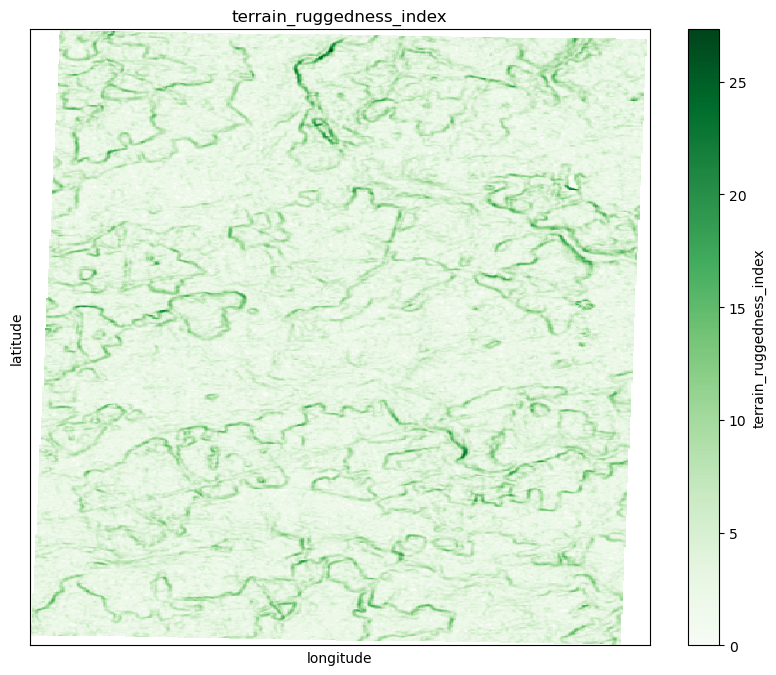

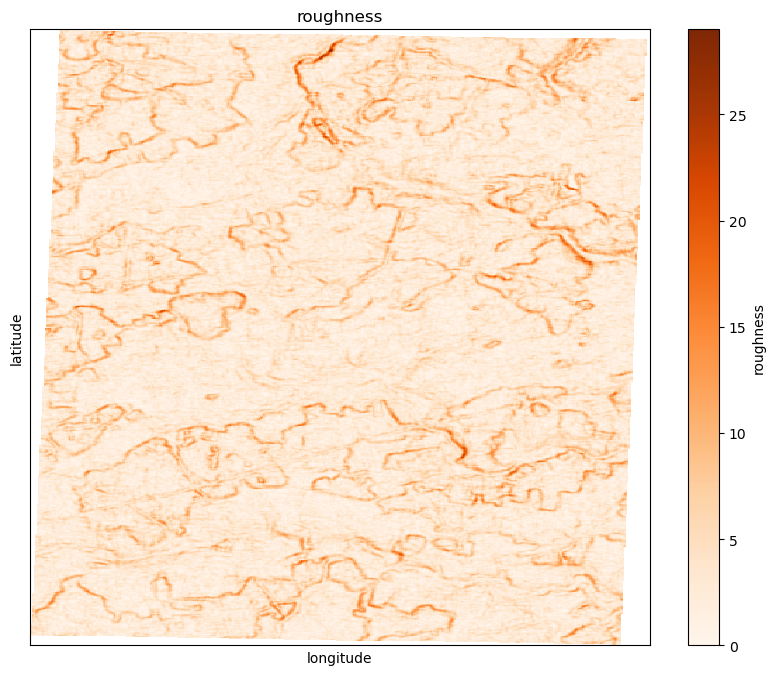

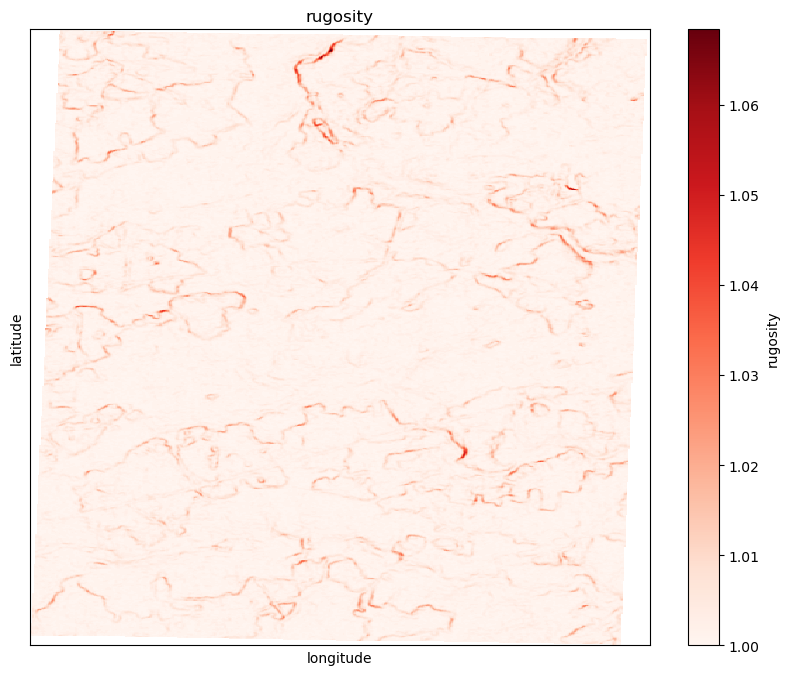

In [ ]:
# Вывод каждого канала на отдельном графике
plot_all_bands(combined_xarray)

In [7]:
for var in combined_xarray.data_vars:
    da = combined_xarray[var]
    # Compute min and max values, skipping NaNs
    min_val = da.min(skipna=True).values
    max_val = da.max(skipna=True).values
    print(f"Variable: {var}")
    print("Data type:", da.dtype)
    print(f"  Range: {min_val} to {max_val}\n")


Variable: reprojected_dem
Data type: float16
  Range: 148.0 to 234.0

Variable: slope
Data type: float16
  Range: 0.0 to 20.53125

Variable: hillshade
Data type: float16
  Range: 135.0 to 229.625

Variable: aspect
Data type: float16
  Range: 0.0 to 359.0

Variable: curvature
Data type: float16
  Range: -1.888671875 to 1.888671875

Variable: planform_curvature
Data type: float16
  Range: -1.111328125 to 1.0556640625

Variable: profile_curvature
Data type: float16
  Range: -1.4443359375 to 1.3525390625

Variable: maximum_curvature
Data type: float16
  Range: -1.4443359375 to 1.3525390625

Variable: topographic_position_index
Data type: float16
  Range: -5.75 to 5.5

Variable: terrain_ruggedness_index
Data type: float16
  Range: 0.0 to 27.3125

Variable: roughness
Data type: float16
  Range: 0.0 to 29.0

Variable: rugosity
Data type: float16
  Range: 1.0 to 1.068359375



In [8]:
# Выводим общие свойства Dataset
print("Dataset dimensions:", combined_xarray.dims)
print("Dataset sizes:", combined_xarray.sizes)
print("Coordinates:\n", combined_xarray.coords)
print("Attributes:\n", combined_xarray.attrs)
total_values = sum(da.size for da in combined_xarray.data_vars.values())
print("Total number of values in the dataset:", total_values)

Dataset dimensions: FrozenMappingWarningOnValuesAccess({'latitude': 754, 'longitude': 441})
Dataset sizes: Frozen({'latitude': 754, 'longitude': 441})
Coordinates:
 Coordinates:
  * longitude    (longitude) float64 4kB 3.782e+05 3.782e+05 ... 3.914e+05
  * latitude     (latitude) float64 6kB 6.174e+06 6.174e+06 ... 6.152e+06
    spatial_ref  int32 4B 0
Attributes:
 {'AREA_OR_POINT': 'Area', 'scale_factor': 1.0, 'add_offset': 0.0}
Total number of values in the dataset: 3990168
